In [1]:
import ae
import tensorflow as tf
import os
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from audioop import rms
from matplotlib.pyplot import ylabel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2022-11-14 05:09:27.535607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 05:09:27.685043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 05:09:28.366133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:/home/can/thesis_ws/devel/lib:/home/can/bfmc_ws/devel/lib:/opt/ros/noetic/lib
2022-11-14 05:09:28.366206: W tensorflow/stream_executor/platform/default/dso_loader.

In [2]:
def testset(test_path, model, dmg=False):
    ae_test = ae.autoEncoder()
    data = []
    names = []
    imgHeight = 48
    imgWidth = 48
    imgChannel = 3
    img_shape = (imgHeight, imgWidth, imgChannel)
    ts_db = os.path.join(test_path)
    for img in os.listdir(ts_db):
        image = Image.open(os.path.join(ts_db, img)).convert('RGB')
        image = image.resize((imgHeight,imgWidth))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        if dmg:
            names.append(img)
    test_data = np.array(data)
    gen = model.predict(test_data)
    tensor_test = tf.convert_to_tensor(test_data, dtype=tf.float32)
    ssim_vals = []
    psnr_vals = []
    rmse_vals = []
    mre_vals = []
    for i in range(len(test_data)):
        ssim_val = ae_test.compMetric(tensor_test[i], gen[i], "SSIM")
        psnr_val = ae_test.compMetric(tensor_test[i], gen[i], "PSNR")
        rmse_val = ae_test.compMetric(tensor_test[i], gen[i], "RMSE")
        mre_val = ae_test.compMetric(tensor_test[i], gen[i], "MRE")

        ssim_vals.append(ssim_val)
        psnr_vals.append(psnr_val/255.0)
        rmse_vals.append(rmse_val)
        mre_vals.append(mre_val)

        if dmg:
            print('Image',names[i],'ssim: ',float(ssim_val),' psnr: ', float(psnr_val/255.0), ' rmse: ', float(rmse_val), ' mre: ', mre_val)

    if dmg == False:
        print("#Instances: ", len(ssim_vals))
    return ssim_vals, psnr_vals, rmse_vals, mre_vals

def visualize(ssim_vals, psnr_vals, rmse_vals, mre_vals, sign):
    std_ssim = np.std(ssim_vals)
    mean_ssim = np.mean(ssim_vals)

    std_psnr = np.std(psnr_vals)
    mean_psnr = np.mean(psnr_vals)

    std_rmse = np.std(rmse_vals)
    mean_rmse = np.mean(rmse_vals)

    std_mre = np.std(mre_vals)
    mean_mre = np.mean(mre_vals)


    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Image Comparison Metrics Distributions of Sign '+sign)


    ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'SSIM Distance', ylabel = "#Instances")

    print("ssim mean: ", mean_ssim, " ssim \u03C3: ", std_ssim, " ssim \u03BC+\u03C3: ", std_ssim+mean_ssim)
    print("ssim \u03BC+1.5\u03C3: ", (1.5)*std_ssim+mean_ssim, " ssim \u03BC+2\u03C3: ", (2.0)*std_ssim+mean_ssim)
    ax.axvline(mean_ssim, color='red', linewidth=2)
    ax.axvline(std_ssim+mean_ssim, color='green', linewidth=2)
    ax.axvline((1.5)*std_ssim+mean_ssim, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_ssim+mean_ssim, color='purple', linewidth=2)


    ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'PSNR Distance', ylabel = "#Instances")
    print("psnr mean: ", mean_psnr, " psnr \u03C3: ", std_psnr, " psnr \u03BC+\u03C3: ", std_psnr+mean_psnr)
    print("psnr \u03BC+1.5\u03C3: ", (1.5)*std_psnr+mean_psnr, " psnr \u03BC+2\u03C3: ", (2.0)*std_psnr+mean_psnr)
    ax.axvline(mean_psnr, color='red', linewidth=2)
    ax.axvline(std_psnr+mean_psnr, color='green', linewidth=2)
    ax.axvline((1.5)*std_psnr+mean_psnr, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_psnr+mean_psnr, color='purple', linewidth=2)

    ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'RMSE Distance', ylabel = "#Instances")
    print("rmse mean: ", mean_rmse, " rmse \u03C3: ", std_rmse, " rmse \u03BC+\u03C3: ", std_rmse+mean_rmse)
    print("rmse \u03BC+1.5\u03C3: ", (1.5)*std_rmse+mean_rmse, " rmse \u03BC+2\u03C3: ", (2.0)*std_rmse+mean_rmse)
    ax.axvline(mean_rmse, color='red', linewidth=2)
    ax.axvline(std_rmse+mean_rmse, color='green', linewidth=2)
    ax.axvline((1.5)*std_rmse+mean_rmse, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_rmse+mean_rmse, color='purple', linewidth=2)

    ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'MRE Distance', ylabel = "#Instances")
    print("mre mean: ", mean_mre, " mre \u03C3: ", std_mre, " mre \u03BC+\u03C3: ", std_mre+mean_mre)
    print("mre \u03BC+1.5\u03C3: ", (1.5)*std_mre+mean_mre, " mre \u03BC+2\u03C3: ", (2.0)*std_mre+mean_mre)
    ax.axvline(mean_mre, color='red', linewidth=2)
    ax.axvline(std_mre+mean_mre, color='green', linewidth=2)
    ax.axvline((1.5)*std_mre+mean_mre, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_mre+mean_mre, color='purple', linewidth=2)



In [3]:
weight_file_cropped_all = "/home/can/thesis/ae_weights/cropped_allfullmodel1mse.h5"
ae_cropped_all = ae.autoEncoder()
model_cropped_all= ae_cropped_all.loadModel(weight_file_cropped_all)

test_path1 = "/home/can/thesis/gtsrb/damaged_signs/1/syn5/"
test_path9 = "/home/can/thesis/gtsrb/damaged_signs/9/syn5/"
test_path14 = "/home/can/thesis/gtsrb/damaged_signs/14/syn5/"
test_path17 = "/home/can/thesis/gtsrb/damaged_signs/17/syn5/"
test_path25 = "/home/can/thesis/gtsrb/damaged_signs/25/syn5/"
test_path39 = "/home/can/thesis/gtsrb/damaged_signs/39/syn5/"

test_path1_dmg = "/home/can/thesis/gtsrb/damaged_signs/1/dmg/"
test_path9_dmg = "/home/can/thesis/gtsrb/damaged_signs/9/dmg/"
test_path14_dmg = "/home/can/thesis/gtsrb/damaged_signs/14/dmg/"
test_path17_dmg = "/home/can/thesis/gtsrb/damaged_signs/17/dmg/"
test_path25_dmg = "/home/can/thesis/gtsrb/damaged_signs/25/dmg/"
test_path39_dmg = "/home/can/thesis/gtsrb/damaged_signs/39/dmg/"

2022-11-14 05:09:29.627450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:09:29.632602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:09:29.632765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:09:29.633355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-11-14 05:09:31.871962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-14 05:09:32.386602: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 1s 6ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.5464436668074794  ssim σ:  0.07934836356570073  ssim μ+σ:  0.6257920303731801
ssim μ+1.5σ:  0.6654662121560304  ssim μ+2σ:  0.7051403939388808
psnr mean:  0.25288293726304  psnr σ:  0.01441690255682262  psnr μ+σ:  0.2672998398198626
psnr μ+1.5σ:  0.27450829109827396  psnr μ+2σ:  0.28171674237668526
rmse mean:  0.16531338  rmse σ:  0.063824  rmse μ+σ:  0.22913738
rmse μ+1.5σ:  0.26104937493801117  rmse μ+2σ:  0.29296137392520905
mre mean:  0.8008477  mre σ:  0.17945169  mre μ+σ:  0.9802994
mre μ+1.5σ:  1.0700252428650856  mre μ+2σ:  1.1597510874271393


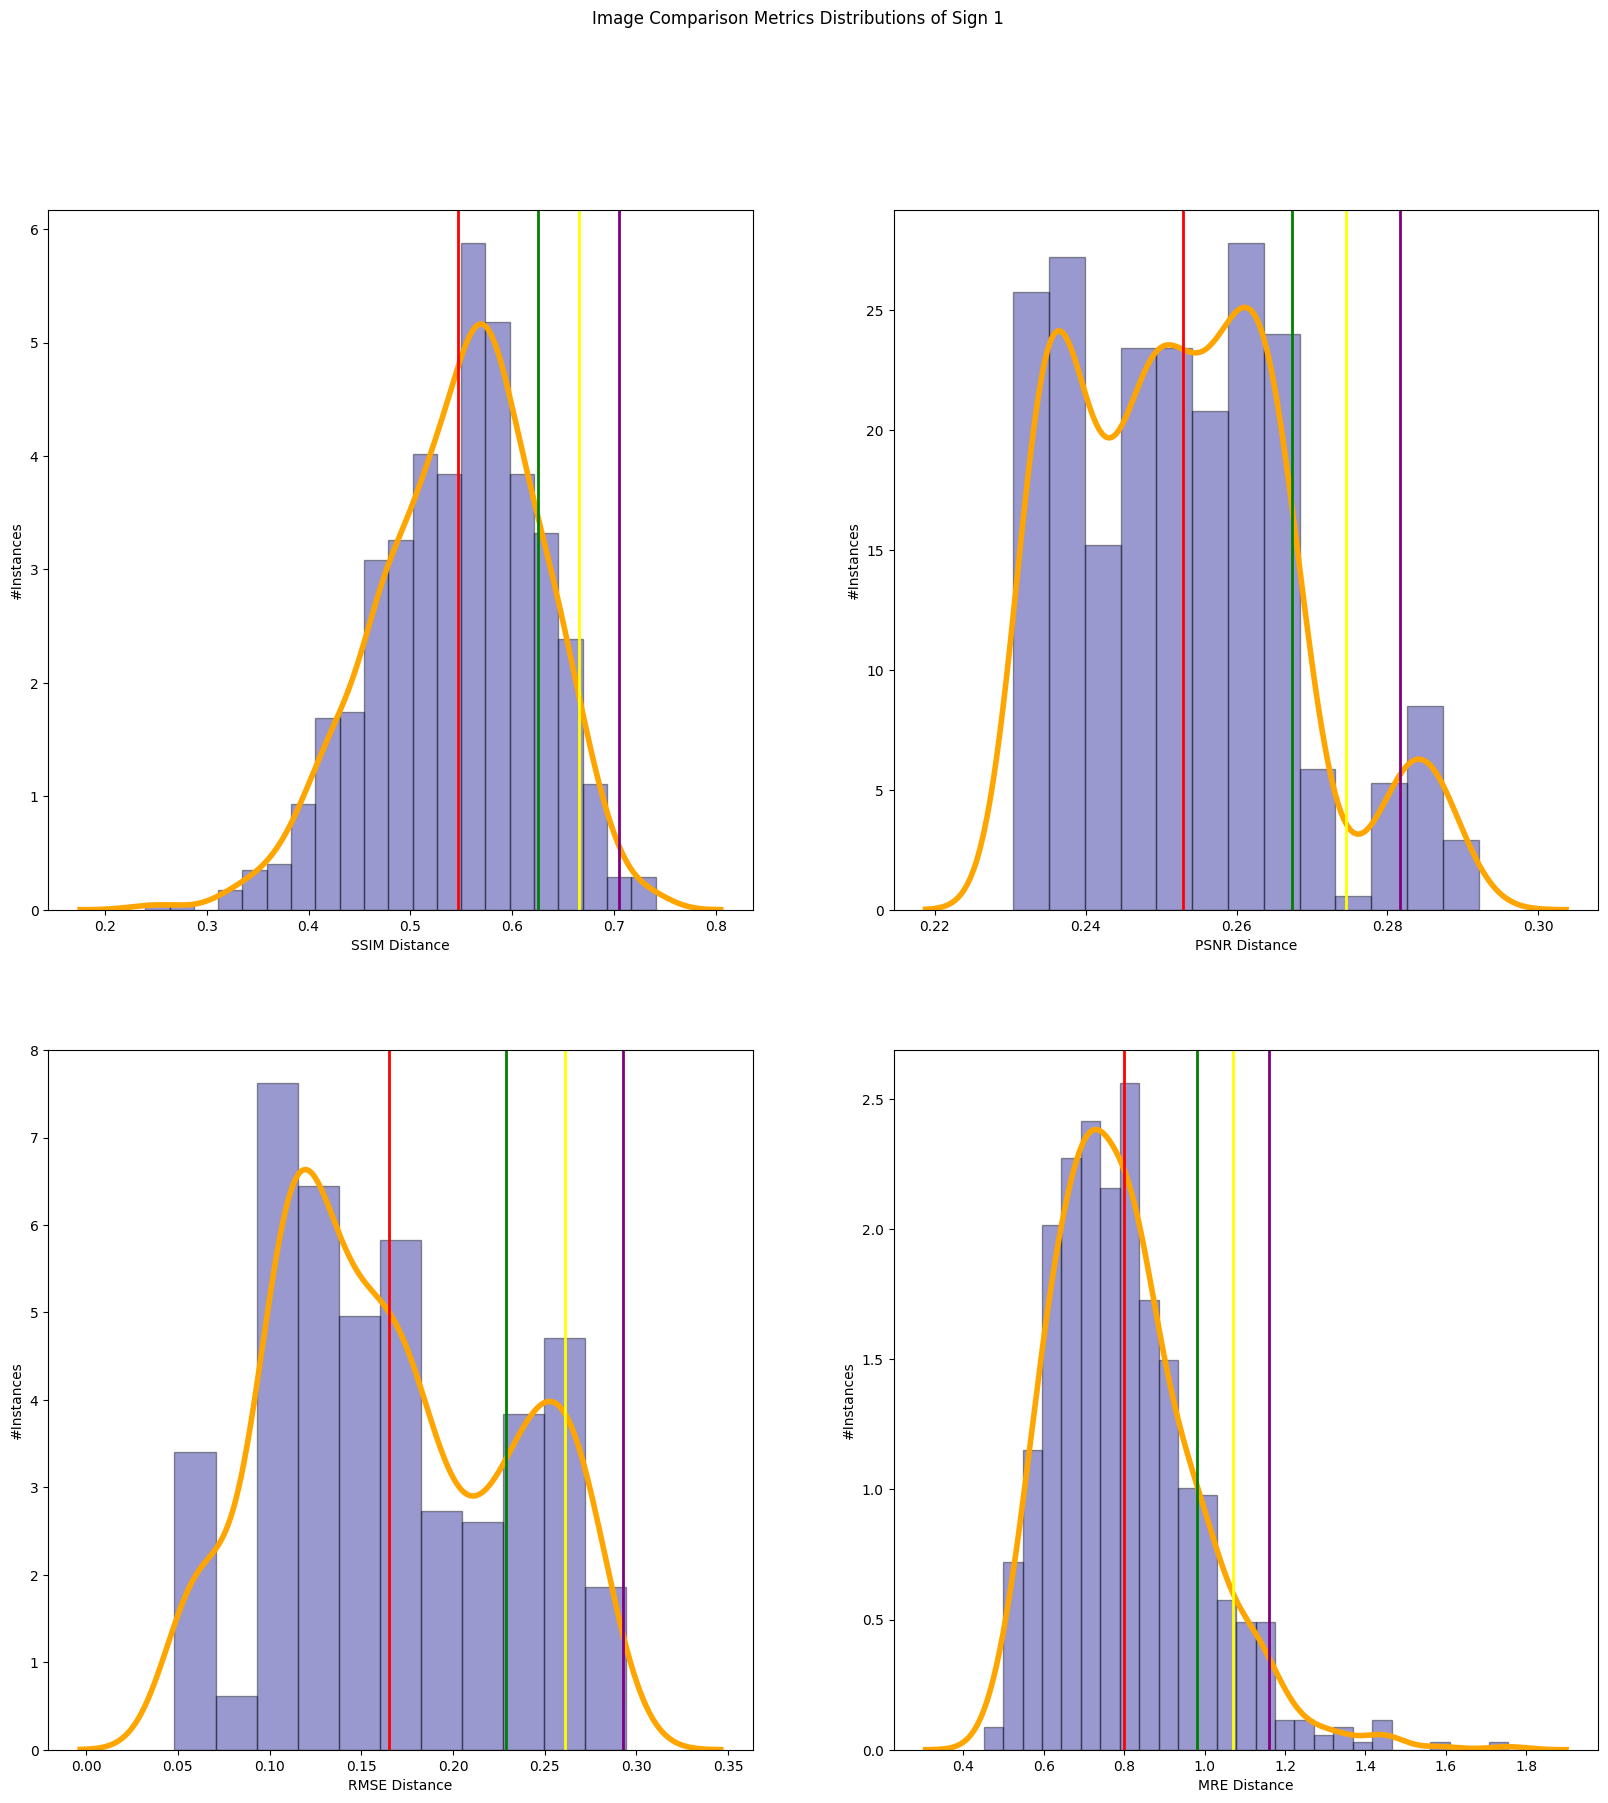

In [4]:
ssim1, psnr1, rmse1, mre1 = testset(test_path1, model_cropped_all)
visualize(ssim1, psnr1, rmse1, mre1, "1")
# _,_,_,_ = testset(test_path1_dmg, model_cropped_all,True)


15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.5000377728293339  ssim σ:  0.09146311729307138  ssim μ+σ:  0.5915008901224053
ssim μ+1.5σ:  0.637232448768941  ssim μ+2σ:  0.6829640074154767
psnr mean:  0.26900051986469947  psnr σ:  0.019141237925781023  psnr μ+σ:  0.2881417577904805
psnr μ+1.5σ:  0.29771237675337103  psnr μ+2σ:  0.3072829957162615
rmse mean:  0.10899173  rmse σ:  0.053680316  rmse μ+σ:  0.16267204
rmse μ+1.5σ:  0.189512200653553  rmse μ+2σ:  0.21635235846042633
mre mean:  0.7278239  mre σ:  0.18064058  mre μ+σ:  0.9084645
mre μ+1.5σ:  0.9987847805023193  mre μ+2σ:  1.0891050696372986


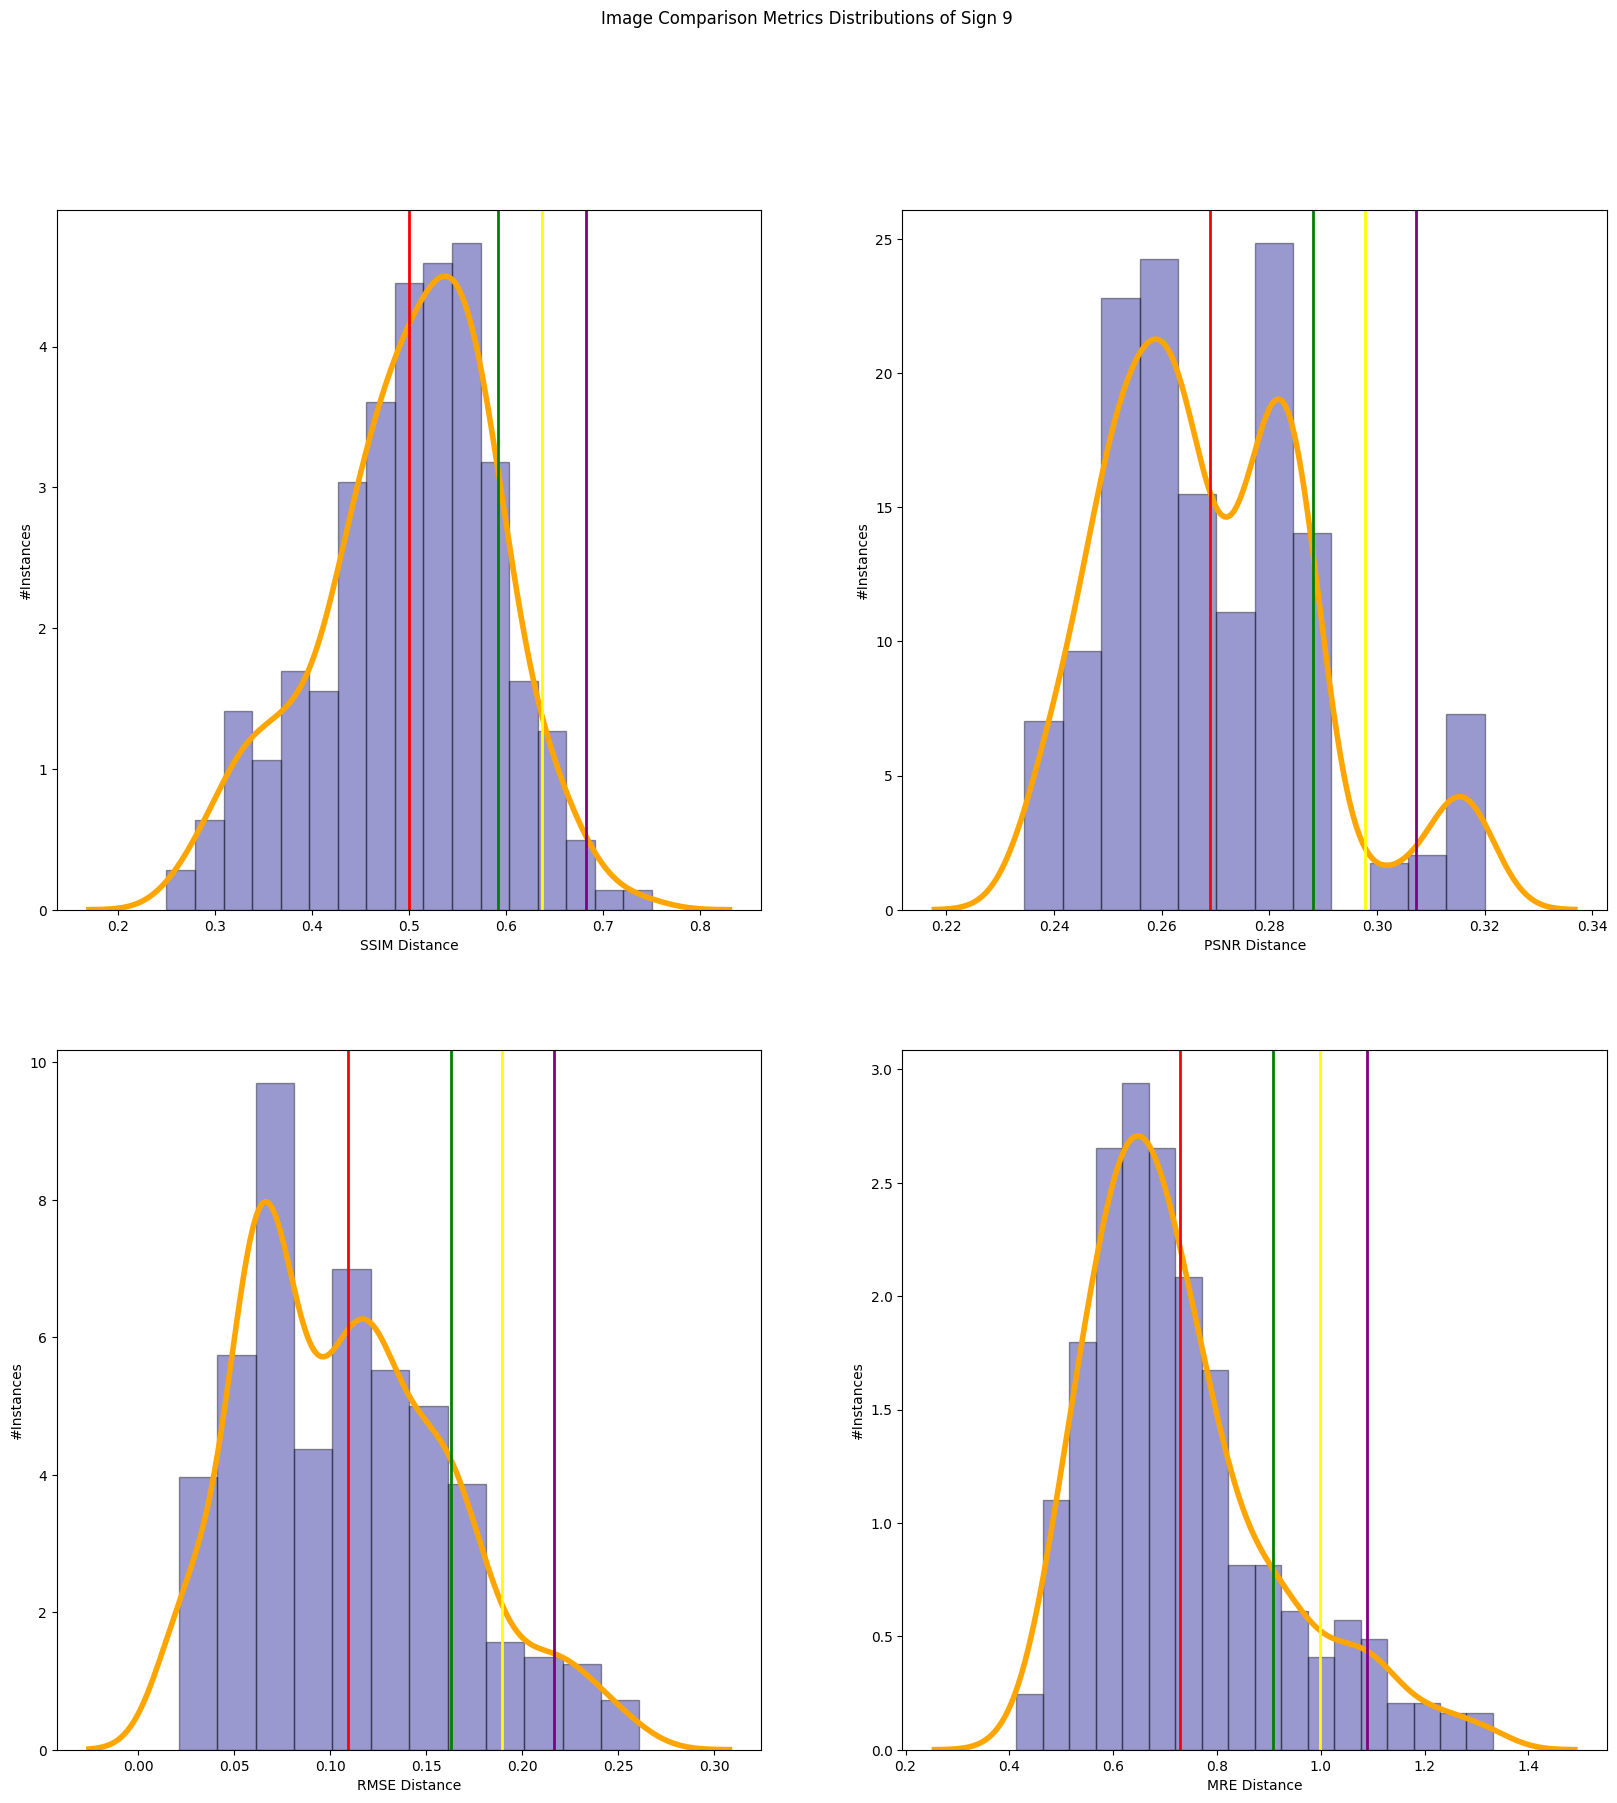

In [5]:
ssim9, psnr9, rmse9, mre9 = testset(test_path9, model_cropped_all)
visualize(ssim9, psnr9, rmse9, mre9,"9")
# _,_,_,_ = testset(test_path9_dmg, model_cropped_all,True)

9/9 [==============================] - 0s 9ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.5387986542450057  ssim σ:  0.08289082122005008  ssim μ+σ:  0.6216894754650558
ssim μ+1.5σ:  0.6631348860750809  ssim μ+2σ:  0.7045802966851059
psnr mean:  0.26128661671668263  psnr σ:  0.0158391993090143  psnr μ+σ:  0.2771258160256969
psnr μ+1.5σ:  0.2850454156802041  psnr μ+2σ:  0.2929650153347112
rmse mean:  0.13079798  rmse σ:  0.05313202  rmse μ+σ:  0.18393001
rmse μ+1.5σ:  0.21049601212143898  rmse μ+2σ:  0.2370620220899582
mre mean:  0.7710762  mre σ:  0.15311667  mre μ+σ:  0.9241929
mre μ+1.5σ:  1.0007512122392654  mre μ+2σ:  1.0773095488548279


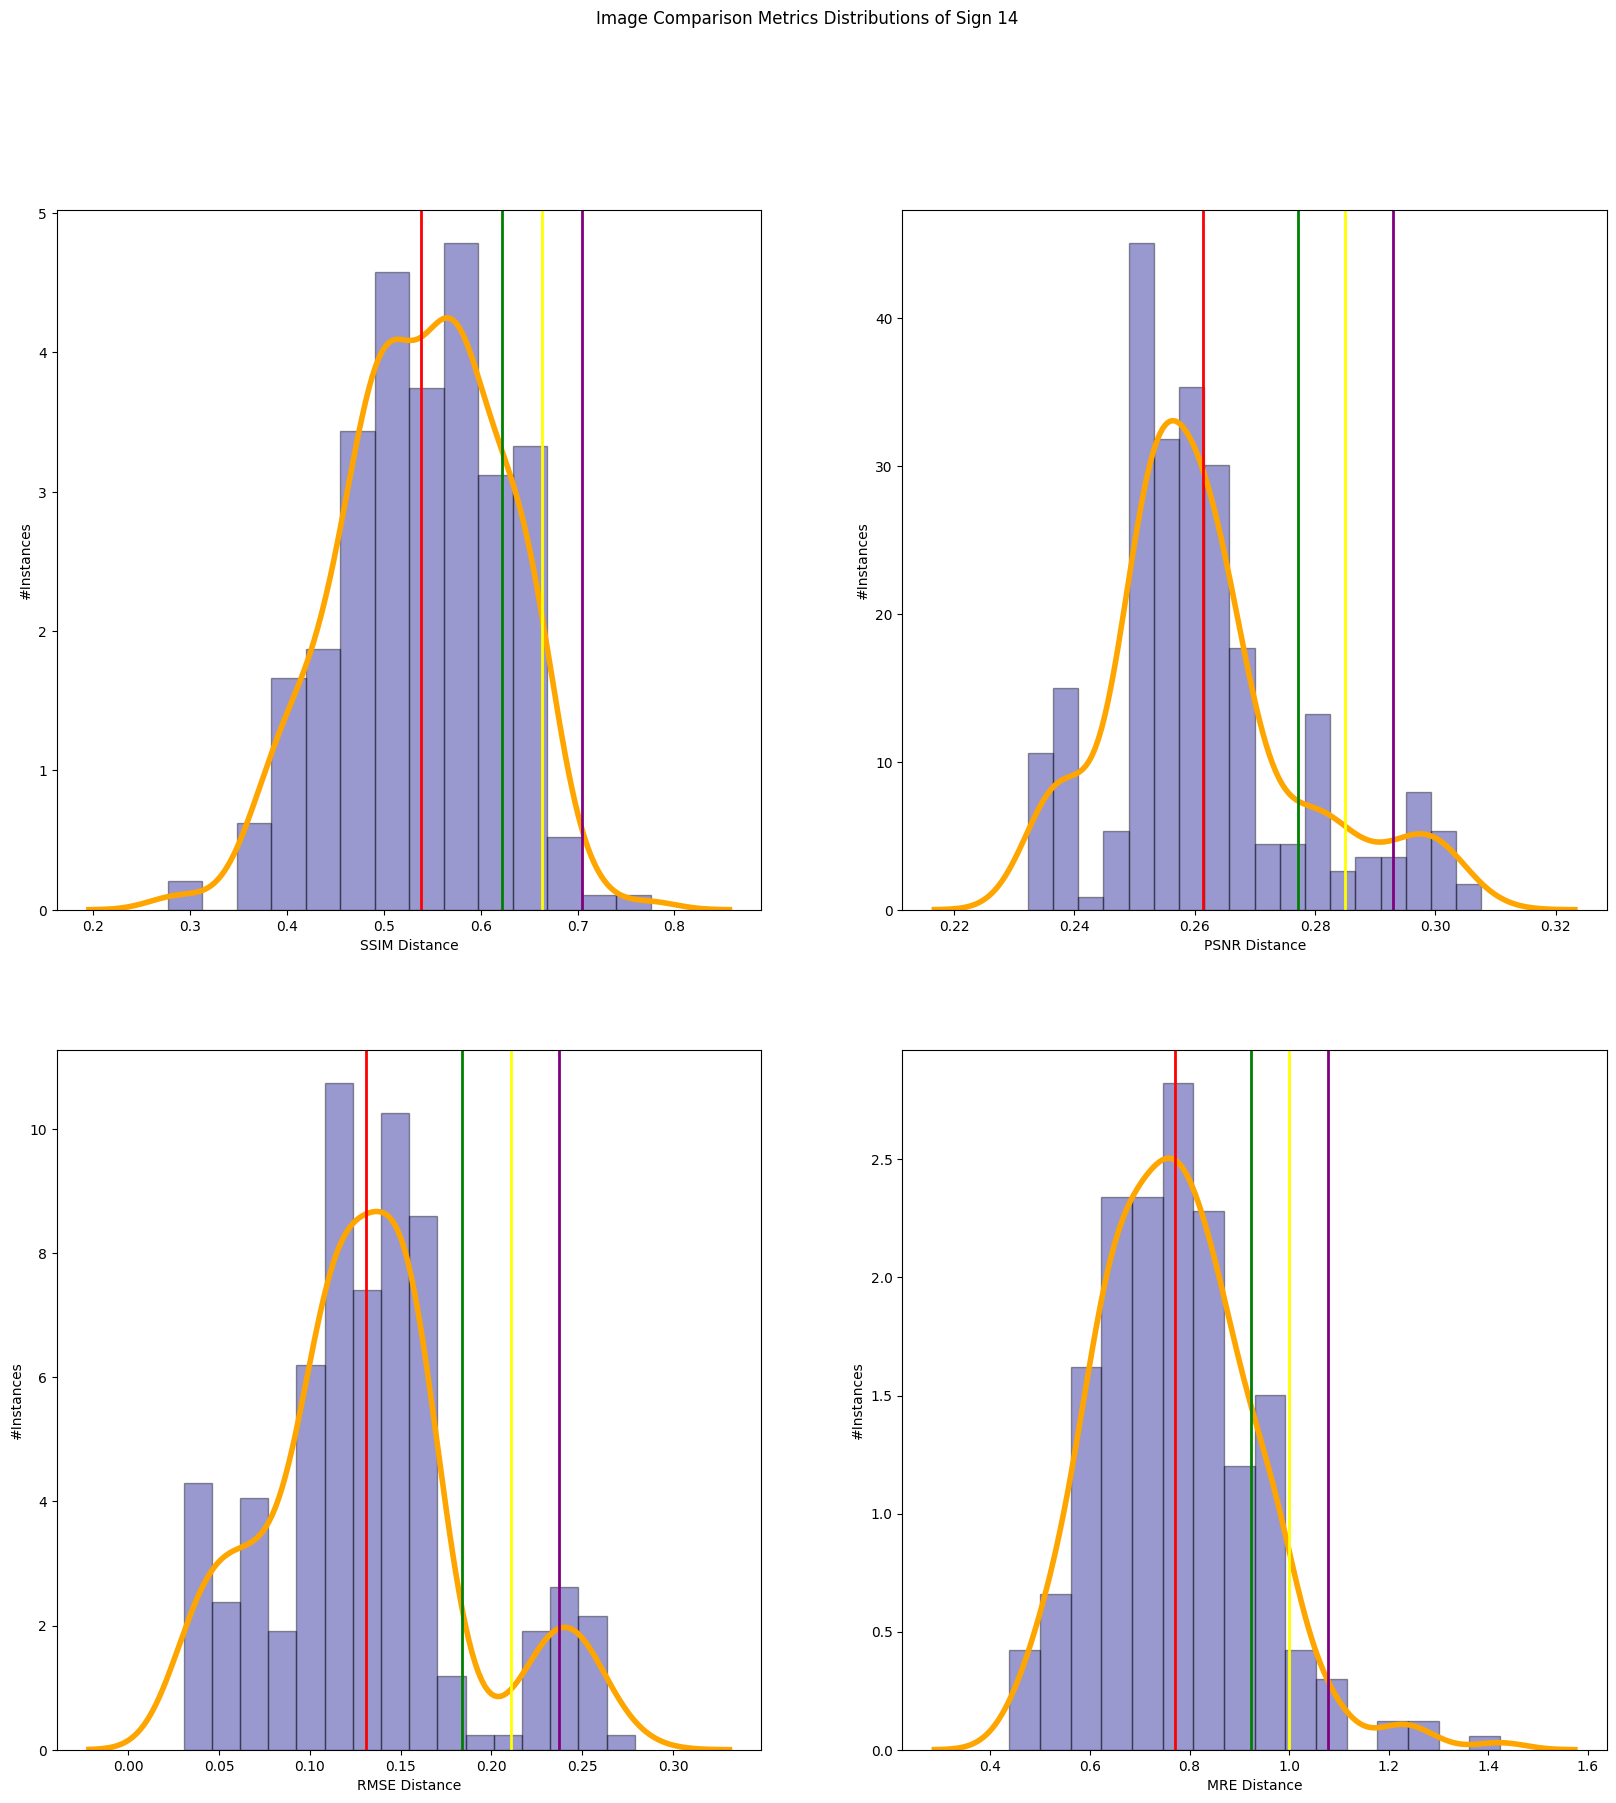

In [6]:
ssim14, psnr14, rmse14, mre14 = testset(test_path14, model_cropped_all)
visualize(ssim14, psnr14, rmse14, mre14,"14")
# _,_,_,_ = testset(test_path14_dmg, model_cropped_all,True)

12/12 [==============================] - 0s 7ms/step
#Instances:  360
Destructor called, Employee deleted.
ssim mean:  0.6164529722183942  ssim σ:  0.06296883737676826  ssim μ+σ:  0.6794218095951625
ssim μ+1.5σ:  0.7109062282835467  ssim μ+2σ:  0.7423906469719308
psnr mean:  0.24924377536981454  psnr σ:  0.01161341048955973  psnr μ+σ:  0.2608571858593743
psnr μ+1.5σ:  0.2666638911041541  psnr μ+2σ:  0.272470596348934
rmse mean:  0.17864408  rmse σ:  0.05443485  rmse μ+σ:  0.23307893
rmse μ+1.5σ:  0.2602963522076607  rmse μ+2σ:  0.28751377761363983
mre mean:  0.8785929  mre σ:  0.2260172  mre μ+σ:  1.1046101
mre μ+1.5σ:  1.2176187187433243  mre μ+2σ:  1.3306273221969604


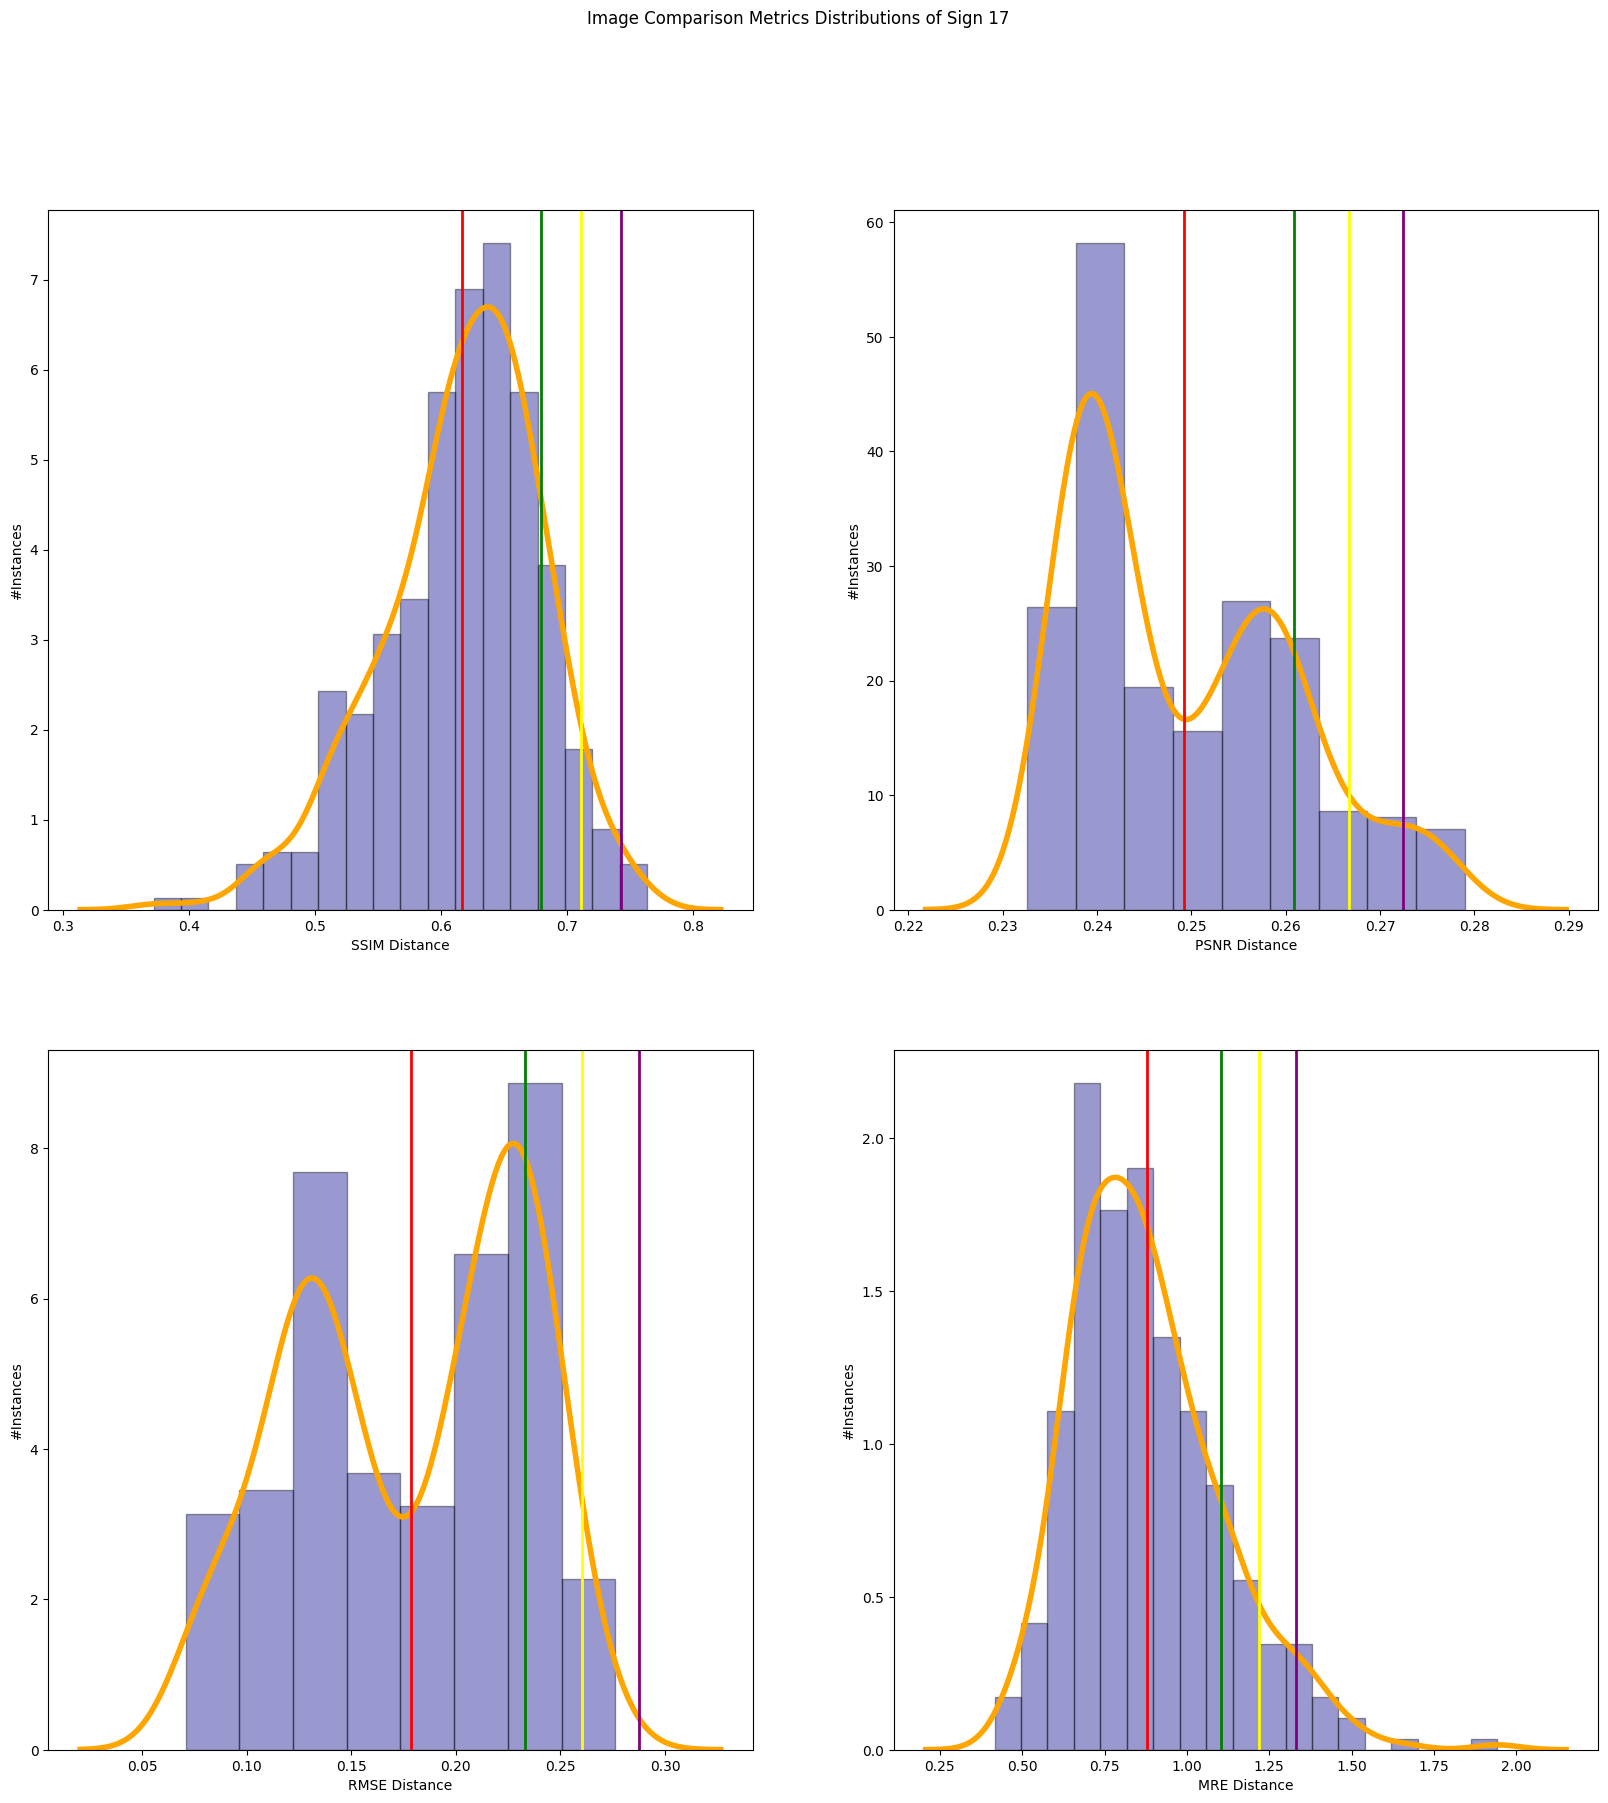

In [7]:
ssim17, psnr17, rmse17, mre17 = testset(test_path17, model_cropped_all)
visualize(ssim17, psnr17, rmse17, mre17,"17")
# _,_,_,_ = testset(test_path17_dmg, model_cropped_all,True)

15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.5594723124367496  ssim σ:  0.09502986937183504  ssim μ+σ:  0.6545021818085845
ssim μ+1.5σ:  0.7020171164945022  ssim μ+2σ:  0.7495320511804197
psnr mean:  0.2543470556284088  psnr σ:  0.015526881008189034  psnr μ+σ:  0.26987393663659787
psnr μ+1.5σ:  0.27763737714069237  psnr μ+2σ:  0.28540081764478686
rmse mean:  0.15851456  rmse σ:  0.055110816  rmse μ+σ:  0.21362537
rmse μ+1.5σ:  0.2411807831376791  rmse μ+2σ:  0.26873619109392166
mre mean:  0.85532075  mre σ:  0.19590221  mre μ+σ:  1.0512229
mre μ+1.5σ:  1.1491740718483925  mre μ+2σ:  1.2471251785755157


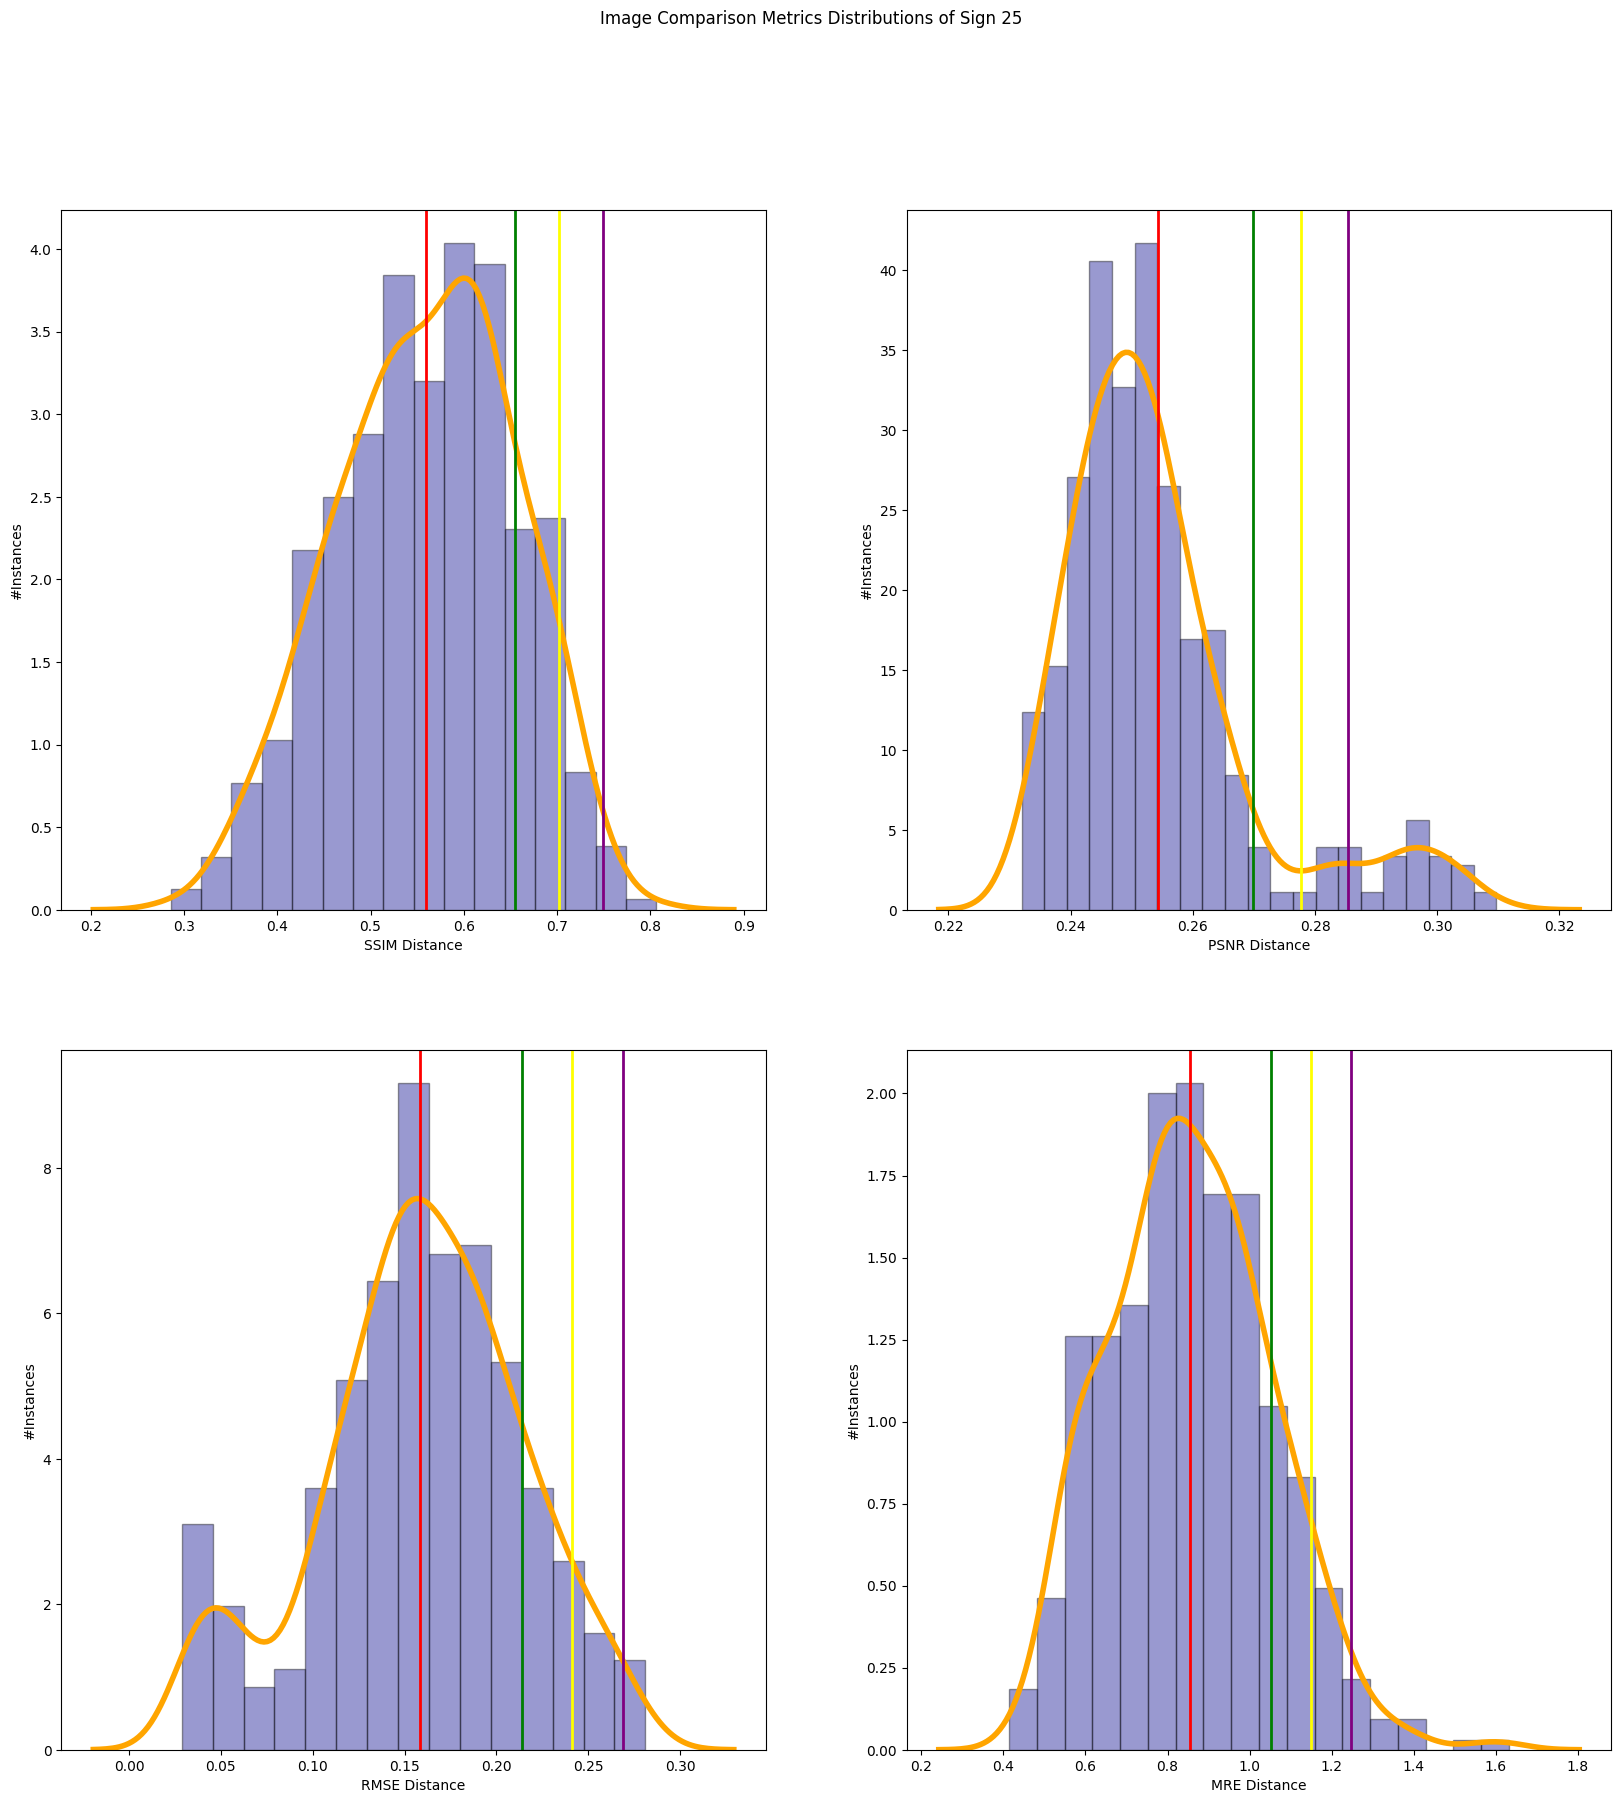

In [8]:
ssim25, psnr25, rmse25, mre25 = testset(test_path25, model_cropped_all)
visualize(ssim25, psnr25, rmse25, mre25,"25")
# _,_,_,_ = testset(test_path25_dmg, model_cropped_all,True)

3/3 [==============================] - 0s 35ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.5206083837482665  ssim σ:  0.10838470832050268  ssim μ+σ:  0.6289930920687692
ssim μ+1.5σ:  0.6831854462290204  ssim μ+2σ:  0.7373778003892718
psnr mean:  0.2602411708125361  psnr σ:  0.031290900656533976  psnr μ+σ:  0.2915320714690701
psnr μ+1.5σ:  0.3071775217973371  psnr μ+2σ:  0.32282297212560407
rmse mean:  0.167393  rmse σ:  0.09507524  rmse μ+σ:  0.26246825
rmse μ+1.5σ:  0.31000586226582527  rmse μ+2σ:  0.357543483376503
mre mean:  0.77070904  mre σ:  0.22657852  mre μ+σ:  0.9972876
mre μ+1.5σ:  1.1105768159031868  mre μ+2σ:  1.2238660752773285


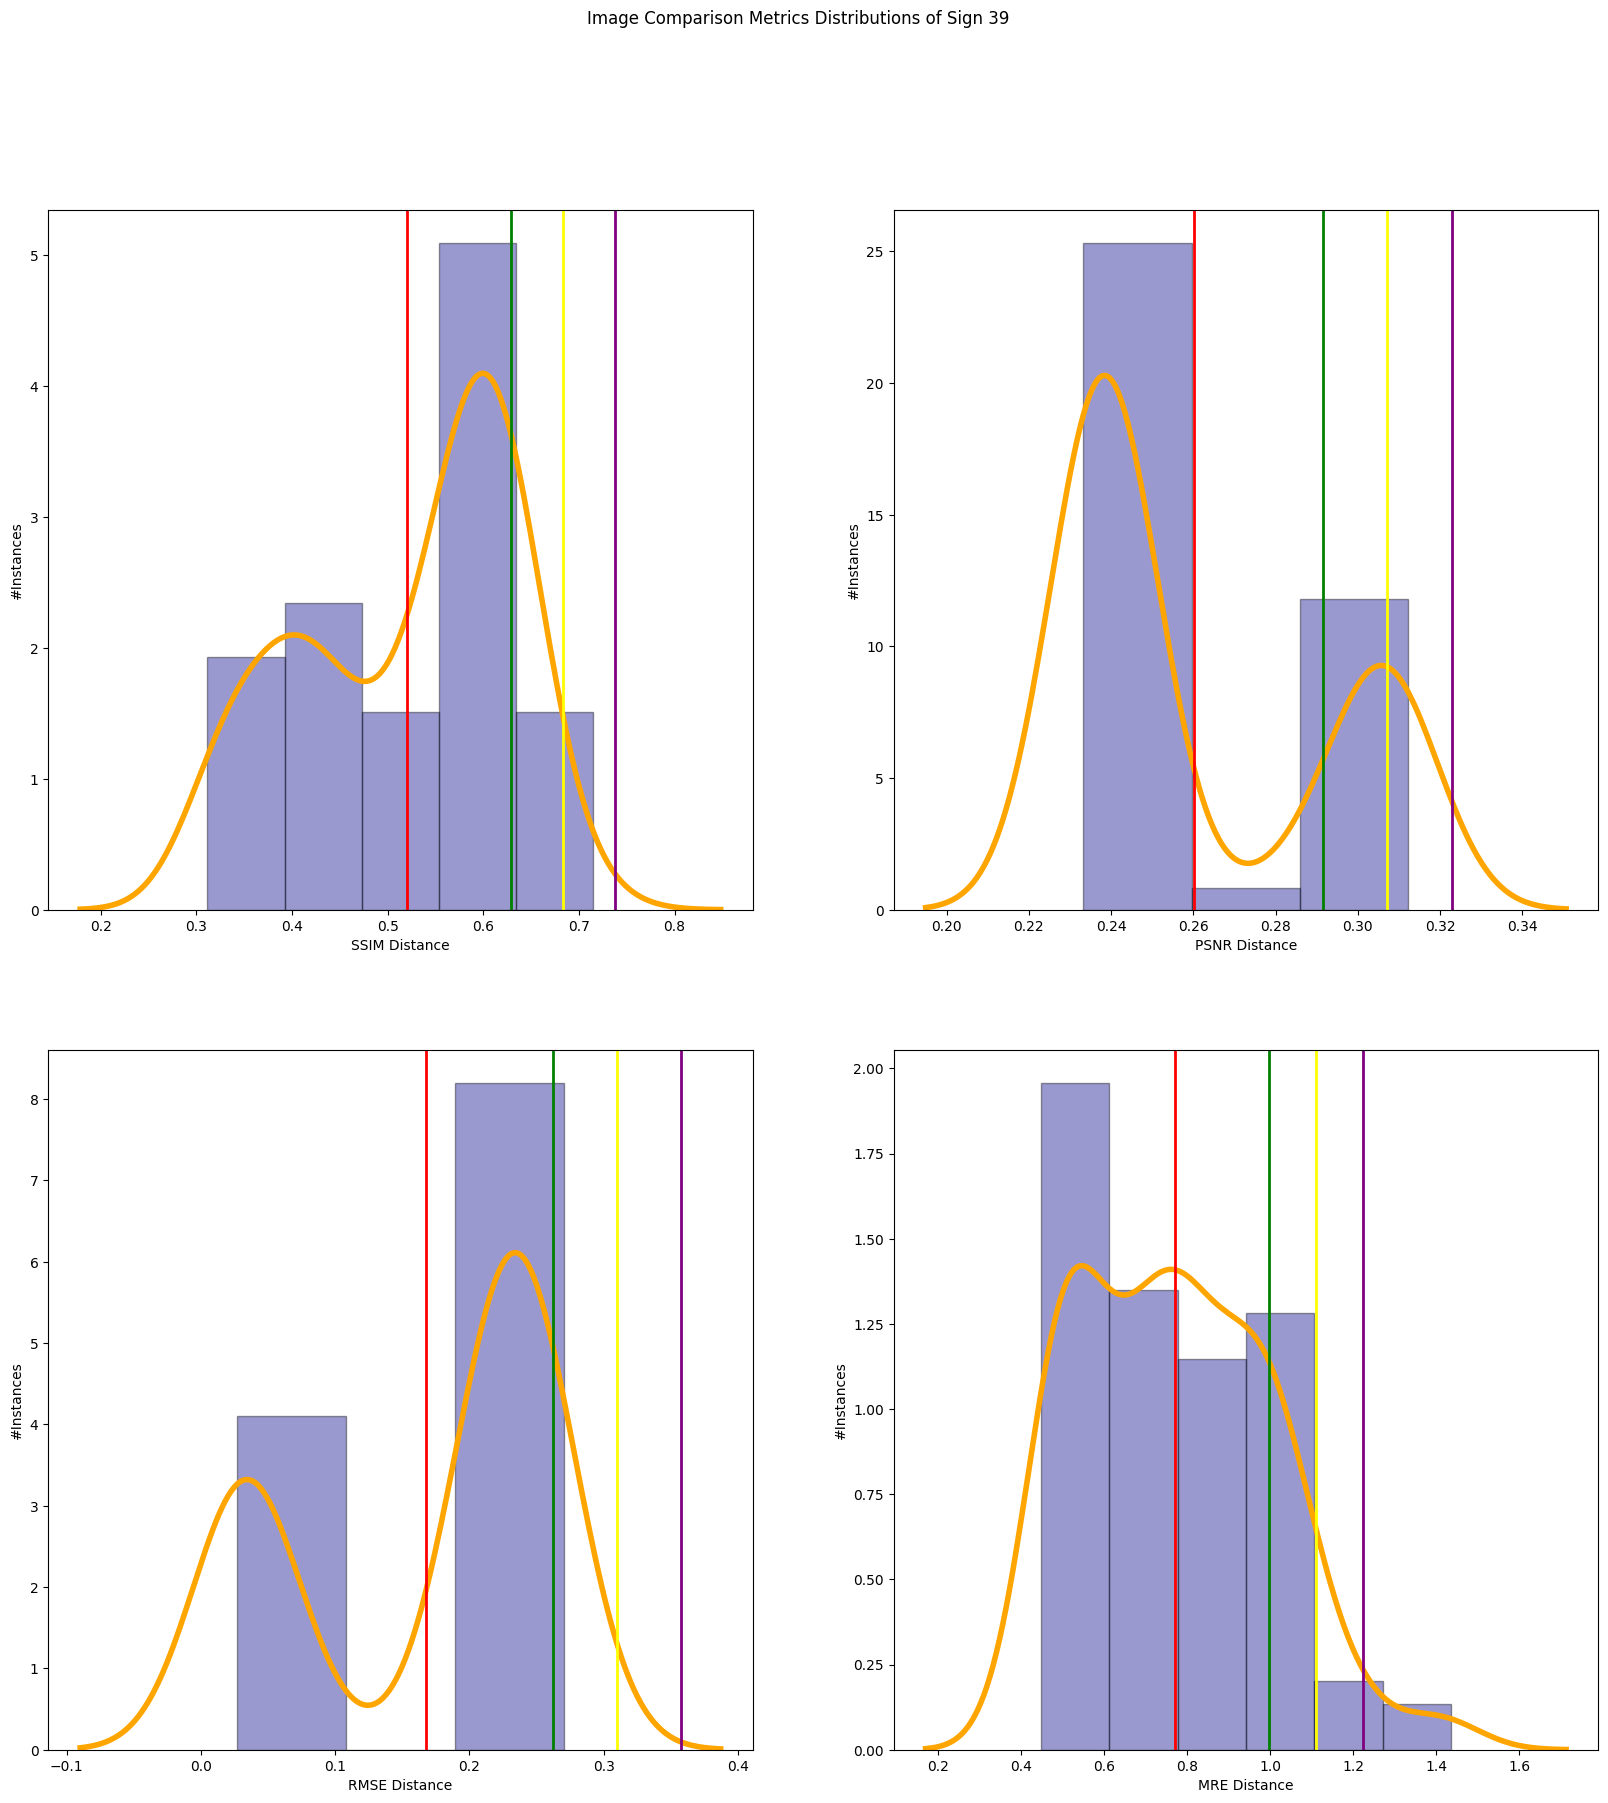

In [9]:
ssim39, psnr39, rmse39, mre39 = testset(test_path39, model_cropped_all)
visualize(ssim39, psnr39, rmse39, mre39,"39")
# _,_,_,_ = testset(test_path39_dmg, model_cropped_all,True)